In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

verified = pd.read_csv("Price Gouging in LA.csv", encoding="ISO-8859-1")
verified = verified.dropna(subset=['Please use this form to submit reports of rental price gouging:'])
unverified =  pd.read_csv("Unverified Gouging.csv", encoding="ISO-8859-1")
unverified = unverified.dropna(subset=['Unnamed: 6'])

verified.columns = verified.iloc[0]  # Set first row as column headers
verified = verified[1:].reset_index(drop=True).iloc[:,:13]  # Remove first row from data
verified['Address'] = (verified['Street Address'] +
                       " " + verified['City'] +
                       ", " + verified['State'] +
                       ", " + verified['ZIP'])

In [ ]:
#Geocoding API
import googlemaps

# Initialize Google Maps API
gmaps = googlemaps.Client(key='...')

def get_lat_lon(address):
    #"""Geocode addresses using Google Maps API."""
    try:
        geocode_result = gmaps.geocode(address)
        if geocode_result:
            lat = geocode_result[0]["geometry"]["location"]["lat"]
            lon = geocode_result[0]["geometry"]["location"]["lng"]
            return pd.Series([lat, lon])
        else:
            return pd.Series([None, None])  # Address not found
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])

verified[['Latitude', 'Longitude']] = verified['Address'].apply(get_lat_lon)

In [200]:
# verified

In [201]:
#Heatmap of Price Gouging
import folium
from folium.plugins import HeatMap

# Create a folium map centered around affected area
m = folium.Map(location=[34.0522, -118.2437], zoom_start=12, tiles = "CartoDB positron")  # Adjust center/zoom as needed

# Filter valid lat/lon
heat_data = verified[['Latitude', 'Longitude']].dropna().values.tolist()

# Add Heatmap Layer
HeatMap(heat_data, radius=14, blur=8).add_to(m)

# Save map
m.save("heatmap.html")
heat_data
import webbrowser

#UNCOMMENT FOR INTERACTIVE MAP
# webbrowser.open("heatmap.html")

In [202]:
#Create an Interactive Map with Clickable Locations
import folium

# Create a folium map
m = folium.Map(location=[34.0522, -118.2437], zoom_start=12)

# Function to create markers
def add_marker(row):
    lat, lon, address, link = row['Latitude'], row['Longitude'], row['Address'], row.get('Link', None)

    # Only add markers for valid coordinates
    if pd.notna(lat) and pd.notna(lon):
        if pd.notna(link):  # If link exists, make clickable
            folium.Marker(
                location=[lat, lon],
                popup_html = folium.Popup(f'<a href="{link}" target="_blank">{address}</a>', max_width=300),
                tooltip=address,
                icon=folium.Icon(color="red", icon="info-sign")
            ).add_to(m)
        else:  # No link, just display address
            folium.Marker(
                location=[lat, lon],
                popup=address,
                tooltip=address,
                icon=folium.Icon(color="blue", icon="info-sign")
            ).add_to(m)

# Apply function to each row
verified.apply(add_marker, axis=1)

# Save map
m.save("interactive_map.html")

#UNCOMMENT FOR INTERACTIVE MAP
# webbrowser.open("interactive_map.html")

In [205]:
# verified[['ZIP',	'Price Before',	'Price After',	'% Increase']]
#.groupby('ZIP').mean()
def dollars_to_int(value):
    if isinstance(value, str):
        return int(value.replace(',', '').replace('$', ''))
    return value  # Return unchanged if it's not a string

verified['Price Before'] = verified['Price Before'].apply(dollars_to_int)
verified['Price After'] = verified['Price After'].apply(dollars_to_int)

vtest = verified.copy()

vtest['% Increase'] =  vtest['% Increase'].str.replace('%','').astype(int)
vtest = vtest[(vtest['Price Before'] > 1) & (vtest['% Increase'] > 10)]

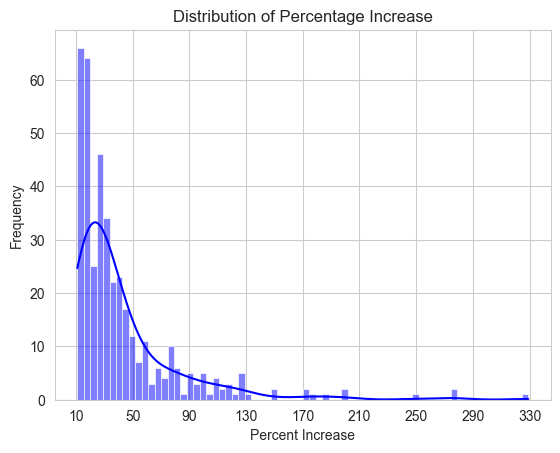

In [207]:
#Histogram

sns.histplot(vtest[vtest['% Increase']<350]['% Increase'], bins=70, kde=True, color='blue')
plt.xticks(range(10,350, 40))  
plt.title('Distribution of Percentage Increase')
plt.xlabel('Percent Increase')
plt.ylabel('Frequency')
plt.show()

C:\Users\nebiu\AppData\Local\Temp\ipykernel_5752\2776008371.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=price_data, x='Severity', order = labels, palette=custom_colors)


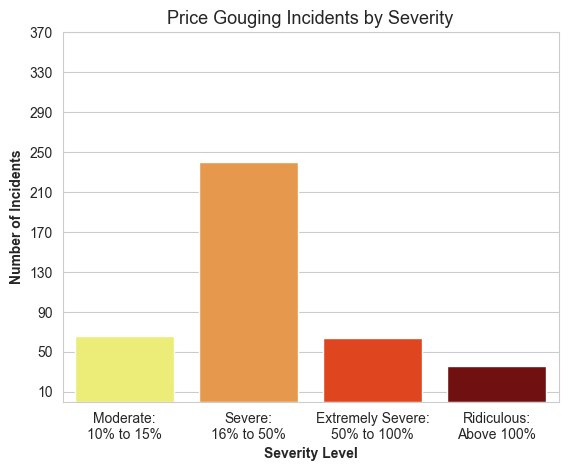

In [208]:
price_data = vtest[vtest.columns[[6,7,8]]]
price_data = price_data.sort_values('% Increase',ascending=False)


def check_gouge(i):
    if i < 16:
        return 'Moderate'
    elif i < 51:
        return 'Severe'
    elif i < 101:
        return 'Extremely Severe'
    else:
        return 'Ridiculous'

price_data['Severity'] = price_data['% Increase'].apply(check_gouge)


bins = [0, 16, 51, 76]
labels = ['Moderate', 'Severe', 'Extremely Severe', 'Ridiculous']
p_labels = ['Moderate:\n10% to 15%', 'Severe:\n16% to 50%', 'Extremely Severe:\n50% to 100%', 'Ridiculous:\nAbove 100%']

sns.set_style("whitegrid")

custom_colors = ['#ffff66', '#ff9933', '#ff3300', '#800000']
sns.countplot(data=price_data, x='Severity', order = labels, palette=custom_colors)

plt.xticks(ticks=range(len(p_labels)), labels=p_labels)
plt.yticks(range(
    10, 
    int(price_data.shape[0]), 
    (int(price_data.shape[0]/10))
))  # Optional: more partitions

plt.title('Price Gouging Incidents by Severity', size=13)
plt.xlabel('Severity Level', fontweight='bold')
plt.ylabel('Number of Incidents', fontweight='bold')

plt.show()